In [18]:
import os
import numpy as np
from scipy import optimize, interpolate
from os.path import join as pjoin
from matplotlib import pyplot as plt

In [2]:
def r_work_scaling(resolution):
    # Acta Cryst. (2009). D65, 1283–1291
    return 0.091 * np.log(resolution) + 0.134

def delta_r_scaling(resolution):
    # Acta Cryst. (2009). D65, 1283–1291
    return 0.024 * np.log(resolution) + 0.020

def r_free_scaling(resolution):
    # Acta Cryst. (2009). D65, 1283–1291
    return r_work_scaling(resolution) + delta_r_scaling(resolution)

In [13]:
def intersection_two_functions(func1, func2, bracket=[2.0, 3.0]):
    diff_func = lambda x : func1(x) - func2(x)
    intersection = optimize.root_scalar(diff_func, bracket=bracket, method='brentq')
    return intersection.root


def find_where_rfactors_intersect_pdb_dist(r_factor_table: np.array) -> float:

    # r_factor_table is (resolution, r_work, r_free)
    # linear interpolate this
    r_work_cs = interpolate.CubicSpline(r_factor_table[:,0], r_factor_table[:,1])
    r_free_cs = interpolate.CubicSpline(r_factor_table[:,0], r_factor_table[:,2])

    r_work_intersection = intersection_two_functions(r_work_cs, r_work_scaling)
    r_free_intersection = intersection_two_functions(r_free_cs, r_free_scaling)

    return r_work_intersection, r_free_intersection

In [49]:
def build_rfactor_table_stack(basedir, timepoint, resolutions):
    """ resulting stack is (refinement_res, r_factor_res, res/r_work/r_free) """

    tables = []

    for res in resolutions:

        timepoint_dir = f"{timepoint}-paired-ref-res{res}"
        table_file = f"{timepoint}_refined{res}_rfactor_table.tsv"
        fn_path = pjoin(basedir, timepoint_dir, table_file)

        assert os.path.exists(fn_path)
        tables.append(np.loadtxt(fn_path))
        
    stack = np.array(tables)

    return stack


def compute_delta_R(rfactor_stack):
    """ returned is an array for the change in R factor over the common set """

    # alternative implementation, harder to understand, but the same
    # r_work_ref_eval_same = np.diag(stack[:,:,1])[:-1]
    # r_work_ref_plus_one = np.diag(stack[1:,:,1])

    delta_rwork = []
    delta_rfree = []

    for i in range(rfactor_stack.shape[0]-1):
        delta_rwork.append(rfactor_stack[i,i,1] - rfactor_stack[i+1,i,1])
        delta_rfree.append(rfactor_stack[i,i,2] - rfactor_stack[i+1,i,2])

    return np.array(delta_rwork), np.array(delta_rfree)

## plot Rwork and Rfree for each resolution cut, 

In [15]:
BASEDIR = "/Users/tjlane/Desktop/PL-workshop/paired-refinement"
RESOLUTIONS = np.linspace(2.0, 3.0, 11)
TIMEPOINTS = ['3ps'] #['3ps', '300ps', '1ns', '3ns', '10ns', '30ns', '1us', '10us', '30us', '100us']

In [26]:
stack = build_rfactor_table_stack(BASEDIR, TIMEPOINTS[0], RESOLUTIONS)
print(stack.shape)

(11, 11, 3)


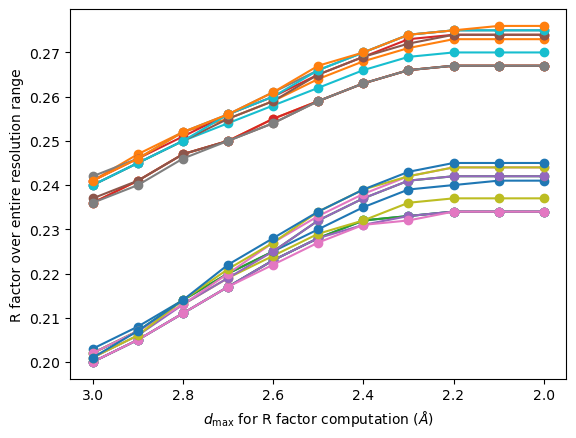

In [55]:
plt.figure()

for i in range(stack.shape[0]):
    substack = stack[i]
    plt.plot(substack[:,0], substack[:,1], 'o-')
    plt.plot(substack[:,0], substack[:,2], 'o-')

plt.xlabel("$d_{\mathrm{max}}$ for R factor computation ($\AA$)")
plt.ylabel("R factor over entire resolution range")
plt.xlim([3.05, 1.95])

plt.show()

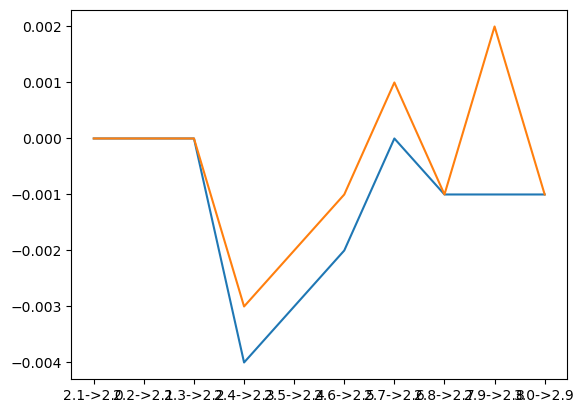

In [62]:
def plot_delta_r(stack, ax):
    ax.plot(compute_delta_R(stack)[0])
    ax.plot(compute_delta_R(stack)[1])

    ax.set_xticks(range(10))
    labels = [f"{RESOLUTIONS[i+1]}->{RESOLUTIONS[i]}" for i in range(10)]
    ax.set_xticklabels(labels)


plt.figure()
ax = plt.subplot(111)



plt.show()